# Neural Network with 5000 games per variant

We will here fit a neural network based on a bigger sample of 5000 games per variant. The methodology to get these games is the same as for the sample that has been used until here and can be found in the notebook "Big sample extraction.ipynb".

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import initializers
from PIL import Image

In [2]:
full_df_5000 = pd.read_pickle('datasets/full_df_5000')

In [3]:
variants = ['antichess', 'atomic', 'blitz', 'chess960', 'crazyhouse', 'horde', 'kingOfTheHill', 'racingKings', 'threeCheck']

# Creating Train/Validation/Test set

As we work now with a different set of data that has 5000 samples per variant, we have to recreate the training, validation and testing sets.  
However, for comparison reasons, we have to keep the same testing set as we used for all other models (i.e. the testing set with 100 sample of each feature).  
We therefore load the testing set that is used in the other units: 

In [4]:
X_te = pd.read_pickle('datasets/X_te')
y_te = pd.read_pickle('datasets/y_te')
testing_set = X_te.join(y_te)

However, these sets were constituted by picking random games from the "yearly arenas" for each variants.  
Therefore, to avoid overfitting, we have to be sure that the games in the testing sets are not present in the "new" training set.  
We therefore select all the games that are in both sets and remove them from the training set. 

In [5]:
# inspired from https://stackoverflow.com/questions/62519791/finding-duplicates-in-two-dataframes-and-removing-the-duplicates-from-one-datafr
df_merge = pd.merge(full_df_5000, testing_set, on=list(full_df_5000.columns), how='inner') # finds games that are in both sets
full_df_5000 = full_df_5000.append(df_merge) # appends the duplicated games to the training set
full_df_5000['Duplicated'] = full_df_5000.duplicated(keep=False) # finds duplicates
full_training = full_df_5000[~full_df_5000['Duplicated']] # selects only rows which are not duplicated.
full_training = full_training.drop('Duplicated', axis=1)

In [6]:
full_training.shape

(43296, 478)

We see that more than 1700 games were removed, which is more than the total number of games in the testing set.  
This is due to the fact that different games have the same positions after 10 moves and all were removed.  
Now, the testing is exactly the same as previously and none of the games in the testing set are present in the training data.  

# Methodlogy

We will tune the Neural Network using keras with grid-search as we did previously for the other models. We do not need to further split the training data into training/validation sets as this is handled internally by the KerasClassifier() with grid-search that we are going to use.  
However, the data has to be prepared.

In [7]:
X_tr = full_training.drop('variant', axis=1)
y_tr = full_training['variant']

In [8]:
X_tr=X_tr.values
X_te=X_te.values
X_tr = X_tr.reshape(X_tr.shape[0], -1)
X_te = X_te.reshape(X_te.shape[0], -1)

In [9]:
y_tr=y_tr.astype('category').cat.codes # converting into integers
y_te=y_te.astype('category').cat.codes

Then, we can create our neural network with Keras and use a grid search of the top of Scikit learn. The following code is highly inspired from my project 4.  

In [10]:
def generate_model(nb_neurons = 64, 
                   activ_fn = 'relu', 
                   optimizer = 'adam', 
                   loss = 'sparse_categorical_crossentropy', 
                   metrics = ['acc']):
    
    # building the model
    model = Sequential()
    model.add(Dense(nb_neurons, # grid search over the nb of neurons in the hidden layer
                    activation = activ_fn,  # test of multiple activating functions
                    input_dim = 477, 
                    kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0)
                   )
             )
    model.add(Dense(9, activation='softmax', kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0)))
    
    # compiling the model
    model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['acc'])
    return model

model = KerasClassifier(build_fn=generate_model, verbose=0)

nb_neurons = [6,8,12,16,32,64,128,256] 
activ_fn = ['relu', 'softmax']    
batch_size = [50]

In [11]:
cv = KFold(n_splits=3, shuffle=True, random_state=0)
param_grid = dict(nb_neurons=nb_neurons, 
                  activ_fn=activ_fn, 
                  epochs=[200], # large number combined with early stopper 
                  batch_size=batch_size)
grid_cv = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    verbose=1, 
                    n_jobs=-1,
                    cv=cv)

As the tuning time is high, we will directly use the best ouputs that are given below:

We can expect an accuracy close to 85.9% on the testing set with the following parameters: 
{'activ_fn': 'relu', 'batch_size': 50, 'epochs': 200, 'nb_neurons': 16}. 
The tuning time is 3214.1 sec.

In [12]:
best_params= {'activ_fn': 'relu', 'batch_size': 50, 'epochs': 200, 'nb_neurons': 16} 
NN_tune_time = 3214.1

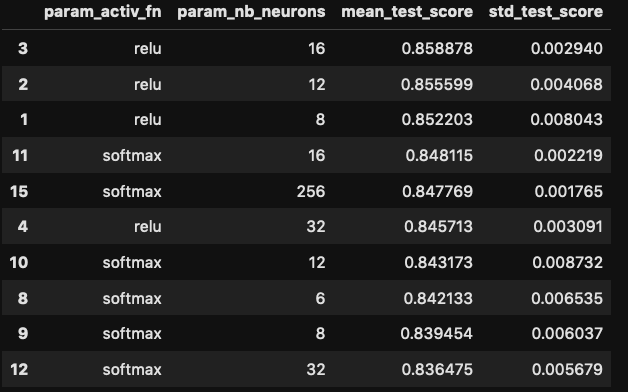

In [13]:
Image.open('Images/Output_tuning_NN.png')

Then, we use the best model that we found: 

In [14]:
nb_neurons = best_params['nb_neurons']
activ_fn = best_params['activ_fn']
epochs = 200
batch_size = 50

final_model = generate_model(nb_neurons=nb_neurons, activ_fn=activ_fn)
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                7648      
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 153       
Total params: 7,801
Trainable params: 7,801
Non-trainable params: 0
_________________________________________________________________


Using the best model:

In [15]:
X_tr, X_va, y_tr, y_va = train_test_split(
    X_tr, y_tr, test_size=1/5, random_state=1, stratify = y_tr)

In [16]:
early_stopping = keras.callbacks.EarlyStopping(monitor='acc', patience = 6)

start_time = time.time()
history = final_model.fit(
    x=X_tr, y=y_tr,
    validation_data=(X_va, y_va),
    batch_size=batch_size, epochs=epochs,
    shuffle=True,
    callbacks=[early_stopping]
)
NN_train_time = time.time() - start_time

Train on 34636 samples, validate on 8660 samples
Epoch 1/200
34636/34636 [==============================] - 2s 62us/step - loss: 0.8715 - acc: 0.7035 - val_loss: 0.5843 - val_acc: 0.7843
Epoch 2/200
34636/34636 [==============================] - 2s 44us/step - loss: 0.5131 - acc: 0.8089 - val_loss: 0.4905 - val_acc: 0.8145
Epoch 3/200
34636/34636 [==============================] - 2s 44us/step - loss: 0.4633 - acc: 0.8242 - val_loss: 0.4617 - val_acc: 0.8221
Epoch 4/200
34636/34636 [==============================] - 2s 44us/step - loss: 0.4378 - acc: 0.8324 - val_loss: 0.4458 - val_acc: 0.8286
Epoch 5/200
34636/34636 [==============================] - 2s 44us/step - loss: 0.4240 - acc: 0.8368 - val_loss: 0.4365 - val_acc: 0.8337
Epoch 6/200
34636/34636 [==============================] - 2s 44us/step - loss: 0.4115 - acc: 0.8422 - val_loss: 0.4310 - val_acc: 0.8334
Epoch 7/200
34636/34636 [==============================] - 2s 44us/step - loss: 0.4045 - acc: 0.8446 - val_loss: 0.4272 - v

Let's visualize how our model did:

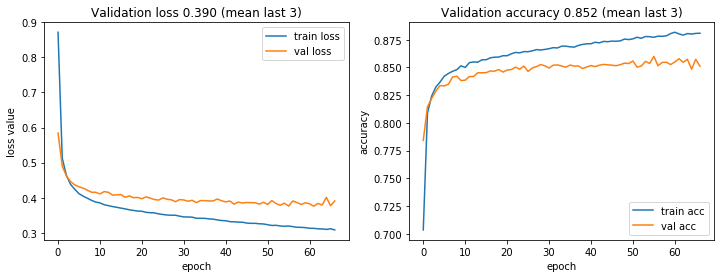

In [17]:
# code from the course

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history.history['acc'], label='train acc')
ax2.plot(history.history['val_acc'], label='val acc')
ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_acc'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()

The validation accuracy isn't very impressive compared to our previous models. Let's see what we get on the testing set.

# Prediction of test set

In [18]:
(NN_loss, NN_accuracy) = final_model.evaluate(X_te, y_te)
print('Test accuracy: {:.2f}%'.format(100*NN_accuracy))

900/900 [==============================] - 0s 36us/step
Test accuracy: 85.44%


In [19]:
y_te_pred = [variants[i] for i in final_model.predict_classes(X_te)] # getting the names of the predicted variants

# Results

In [20]:
NN_conf=pd.DataFrame(confusion_matrix(y_te_pred, pd.read_pickle('datasets/y_te')), index=variants, columns=variants)/100
NN_conf

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.95,0.00,0.01,0.0,0.03,0.0,0.00,0.0,0.00
atomic,0.04,0.99,0.01,0.0,0.00,0.0,0.01,0.0,0.02
blitz,0.00,0.00,0.78,0.0,0.18,0.0,0.35,0.0,0.15
chess960,0.00,0.00,0.00,1.0,0.00,0.0,0.00,0.0,0.00
crazyhouse,0.00,0.01,0.00,0.0,0.62,0.0,0.01,0.0,0.01
horde,0.00,0.00,0.00,0.0,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.01,0.00,0.12,0.0,0.06,0.0,0.57,0.0,0.04
racingKings,0.00,0.00,0.00,0.0,0.00,0.0,0.00,1.0,0.00
threeCheck,0.00,0.00,0.08,0.0,0.11,0.0,0.06,0.0,0.78


In [21]:
NN_metrics=pd.DataFrame(classification_report(y_te_pred, pd.read_pickle('datasets/y_te'), output_dict=True)).T.round(3)
NN_metrics

,f1-score,precision,recall,support
antichess,0.955,0.950,0.960,99.0
atomic,0.957,0.990,0.925,107.0
blitz,0.634,0.780,0.534,146.0
chess960,1.000,1.000,1.000,100.0
crazyhouse,0.752,0.620,0.954,65.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.633,0.570,0.712,80.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.768,0.780,0.757,103.0
micro avg,0.854,0.854,0.854,900.0


In [22]:
NN_scores_avg=list(NN_metrics.loc['weighted avg',:])[:3]
NN_scores_blitz=list(NN_metrics.loc['blitz',:])

In [25]:
results_NN_5000=pd.DataFrame({
    'NN_5000': [NN_accuracy, NN_tune_time, NN_train_time, NN_scores_avg[0], NN_scores_avg[1], NN_scores_avg[2], NN_scores_blitz[0], NN_scores_blitz[1], NN_scores_blitz[2], NN_scores_blitz[3]],
}, index = ['Accuracy', 'Tuning time', 'Training time', 'f1_avg', 'precision_avg', 'recall_avg', 'f1_blitz', 'precision_blitz', 'recall_blitz', 'support_blitz']).round(3).T.sort_values('Accuracy', ascending=False)
results_full

,Accuracy,Tuning time,Training time,f1_avg,precision_avg,recall_avg,f1_blitz,precision_blitz,recall_blitz,support_blitz
NN_5000,0.854,3214.1,107.456,0.853,0.867,0.854,0.634,0.78,0.534,146.0


In [26]:
results_NN_5000.to_pickle('datasets/results_NN_5000')

Unfortunatelly, we did not achieve to get a better performance than our previous "more simple" models that we fit in the other sections.